In [51]:
import tensorflow as tf
for device in tf.config.list_physical_devices():
    print(": {}".format(device.name))

: /physical_device:CPU:0
: /physical_device:GPU:0


In [52]:
# Import all necessary libraries
import os
import logging
import warnings
import numpy as np
import matplotlib.pyplot as plt

# Suppress warnings and logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel(logging.ERROR)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Define constants
IMAGE_SIZE = (224, 224)  # Directly using ResNet50 input size
BATCH_SIZE = 64
TRAINING_DATA_PATH = "Final_Arabic_Alpha_dataset/train"
TEST_DATA_PATH = "Final_Arabic_Alpha_dataset/test"

# Load datasets
print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.1,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAINING_DATA_PATH,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='int'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DATA_PATH,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode=None,
    shuffle=False
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Loading datasets...
Found 42559 files belonging to 65 classes.
Using 38304 files for training.
Found 42559 files belonging to 65 classes.
Using 4255 files for validation.
Found 10640 files belonging to 1 classes.
Class names: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '7', '8', '9']


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
import keras_tuner as kt

def build_model(hp):
    # Load the pre-trained model
    loaded_model2 = tf.keras.models.load_model("arabic_letter_classifier_95_87")
    
    old_weights2 = loaded_model2.layers[-1].get_weights()
    
    x = loaded_model2.layers[-2].output  # Target the last Dense layer before softmax

    # Use a tunable dropout rate
    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.05)
    x = Dropout(dropout_rate, name="tuned_dropout")(x)  # Add Dropout

    x = Dense(len(class_names), activation='softmax', name="new_output")(x)  # Rename new Dense layer

    # Create new model (Keeps trained weights)
    new_model2 = Model(inputs=loaded_model2.input, outputs=x)

    # Set the pre-trained weights back
    new_model2.layers[-1].set_weights(old_weights2)  # Restore softmax layer weights

    # Recompile the model
    new_model2.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=['accuracy']
    )

    return new_model2

# Define Keras Tuner search strategy
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=5,
    factor=3,
    directory="keras_tuner_results",
    project_name="dropout_tuning"
)

# Run the search
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

# Get the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best Dropout Rate: {best_hps.get('dropout_rate')}")

Trial 10 Complete [00h 09m 39s]
val_accuracy: 0.8686251640319824

Best val_accuracy So Far: 0.8716803789138794
Total elapsed time: 01h 01m 23s
Best Dropout Rate: 0.1


In [4]:
# Rebuild the best model using the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model again
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)

Epoch 1/5
599/599 [==============================] - 116s 191ms/step - loss: 0.2667 - accuracy: 0.9137 - val_loss: 0.4026 - val_accuracy: 0.8722
Epoch 2/5
599/599 [==============================] - 117s 195ms/step - loss: 0.2605 - accuracy: 0.9162 - val_loss: 0.4014 - val_accuracy: 0.8722
Epoch 3/5
599/599 [==============================] - 116s 193ms/step - loss: 0.2560 - accuracy: 0.9183 - val_loss: 0.4014 - val_accuracy: 0.8719
Epoch 4/5
599/599 [==============================] - 118s 197ms/step - loss: 0.2516 - accuracy: 0.9206 - val_loss: 0.4009 - val_accuracy: 0.8700
Epoch 5/5
599/599 [==============================] - 118s 197ms/step - loss: 0.2485 - accuracy: 0.9235 - val_loss: 0.4000 - val_accuracy: 0.8707


In [53]:
loaded_model = tf.keras.models.load_model("arabic_letter_classifier_95_95")

In [4]:
loss, accuracy = loaded_model.evaluate(train_ds)
val_loss, val_accuracy = loaded_model.evaluate(val_ds)

print(f"Training loss: {loss}, Training Accuracy: {accuracy}")
print(f"Val loss: {val_loss}, Val Accuracy: {val_accuracy}")

67/67 [==============================] - 13s 184ms/step - loss: 0.1915 - accuracy: 0.9452
Training loss: 0.02397003211081028, Training Accuracy: 0.9921940565109253
Val loss: 0.19145986437797546, Val Accuracy: 0.9452409148216248


In [54]:
import numpy as np
from sklearn.metrics import classification_report

# Collect true labels and predictions
all_labels = []
all_preds = []

for images, labels in val_ds:
    preds = loaded_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)  # Get predicted class indices
    all_labels.extend(labels.numpy())
    all_preds.extend(preds)

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Print a full classification report
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94        62
           1       0.99      0.99      0.99        68
          10       0.92      0.88      0.90        68
          11       0.91      0.87      0.89        77
          12       0.96      0.98      0.97        48
          13       0.90      0.91      0.91        70
          14       0.85      0.83      0.84        53
          15       0.83      0.92      0.87        59
          16       0.91      0.87      0.89        77
          17       0.85      0.87      0.86        61
          18       0.89      0.85      0.87        73
          19       0.96      0.96      0.96        56
           2       0.99      0.97      0.98        70
          20       1.00      0.97      0.98        65
          21       0.96      0.98      0.97        51
          22       0.94      0.97      0.95        64
          23       1.00      0.95      0.98        86
          24       0.93    

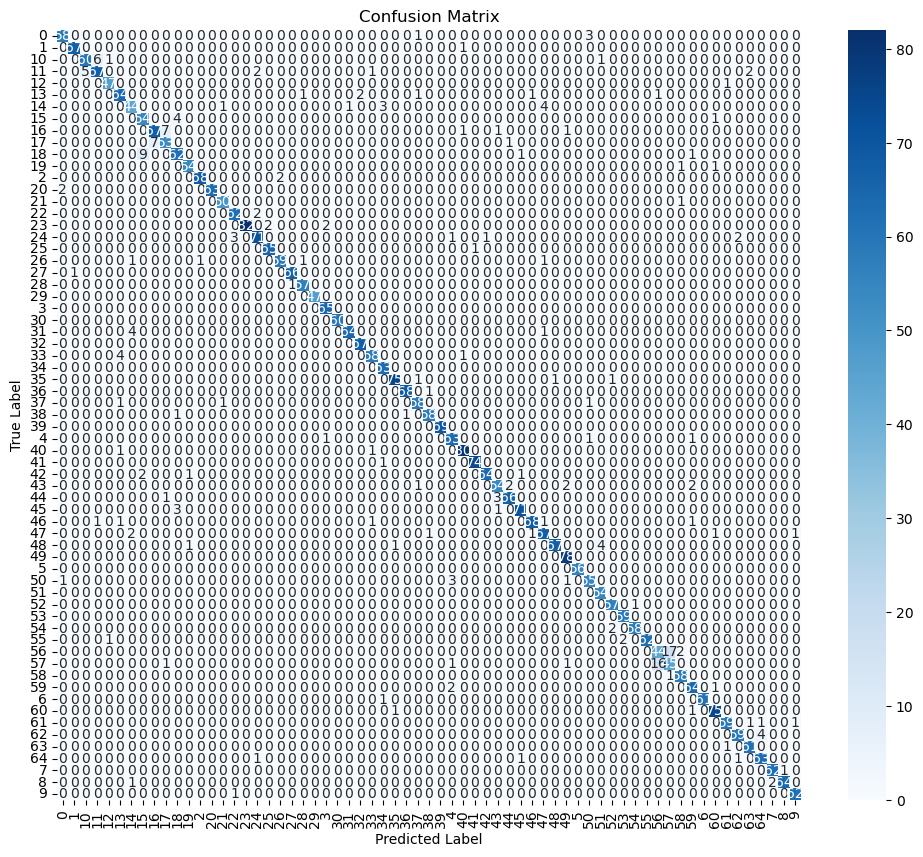

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_labels and all_preds are already computed as in your code
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Sample misclassifications:
Sample 0: True index: 25 -> 31, Pred index: 6 -> 14
Sample 1: True index: 39 -> 44, Pred index: 38 -> 43
Sample 2: True index: 19 -> 26, Pred index: 42 -> 47
Sample 3: True index: 9 -> 17, Pred index: 8 -> 16
Sample 4: True index: 5 -> 13, Pred index: 21 -> 28
Total misclassified samples: 233


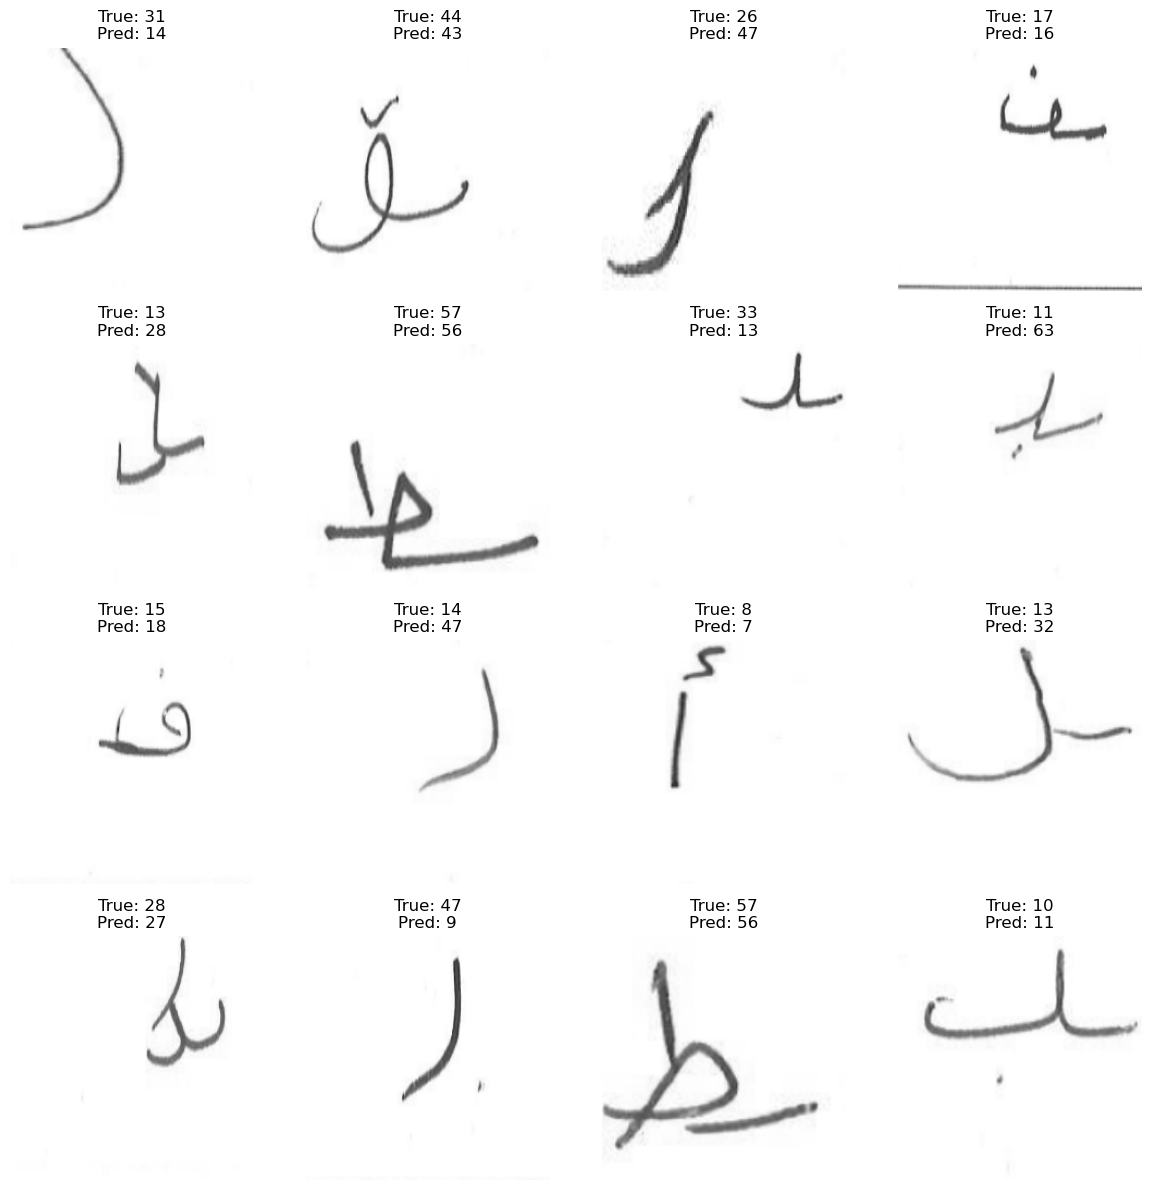

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Lists to store misclassified samples
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get predictions for the batch
    preds = loaded_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    
    # Loop through the batch and collect misclassified samples
    for i in range(len(labels)):
        true_label = int(labels[i].numpy())
        pred_label = int(preds[i])
        if pred_label != true_label:
            misclassified_images.append(images[i])
            misclassified_true_labels.append(true_label)
            misclassified_pred_labels.append(pred_label)

# Debug: print the first few misclassifications
print("Sample misclassifications:")
for i in range(min(5, len(misclassified_true_labels))):
    print(f"Sample {i}: True index: {misclassified_true_labels[i]} -> {class_names[misclassified_true_labels[i]]}, " 
          f"Pred index: {misclassified_pred_labels[i]} -> {class_names[misclassified_pred_labels[i]]}")

print(f"Total misclassified samples: {len(misclassified_images)}")

# Plot a selection of misclassified images (e.g., 16 images)
n_to_show = min(16, len(misclassified_images))
plt.figure(figsize=(12, 12))
for i in range(n_to_show):
    ax = plt.subplot(4, 4, i+1)
    # Convert image tensor to uint8 for proper display
    plt.imshow(misclassified_images[i].numpy().astype("uint8"))
    true_label_name = class_names[misclassified_true_labels[i]]
    pred_label_name = class_names[misclassified_pred_labels[i]]
    plt.title(f"True: {true_label_name}\nPred: {pred_label_name}")
    plt.axis("off")
plt.tight_layout()
plt.show()